# Demonstrate `eulerian.Position` object with Fjord

Author: Wenrui Jiang, 14 June 2023

The `eulerian.Position` object is really what connects a point and the numerical model. Its `interpolate` method really is the core of this package. We're going to use a rather interesting example to demonstrate the functionalities of `eulerian.Position`.

In [1]:
import oceanspy as ospy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaduck as sd
from functools import partial
import xarray as xr
import cmocean

mpl.rcParams["figure.dpi"] = 300

Here on [SciServer](https://sciserver.org/), we have an interesting dataset simulating the interaction between background circulation and Kangerdlugssuaq Fjord. More information can be found below, and see the paper by [Fraser et al., 2018](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018JC014435):

In [2]:
fjord = ospy.open_oceandataset.from_catalog("KangerFjord")

Opening KangerFjord.
A realistic numerical model constructed to simulate the oceanic conditions
and circulation in a large southeast Greenland fjord (Kangerdlugssuaq) and
the adjacent shelf sea region during winter 2007–2008.
Citation:
 * Fraser et al., 2018 - JGR.


```
Opening KangerFjord.
A realistic numerical model constructed to simulate the oceanic conditions
and circulation in a large southeast Greenland fjord (Kangerdlugssuaq) and
the adjacent shelf sea region during winter 2007–2008.
Citation:
 * Fraser et al., 2018 - JGR.
```

Let's first explore the dataset a bit. We are going to use [ETOPO](https://www.ncei.noaa.gov/products/etopo-global-relief-model) dataset to give you an idea where this domain is located.

In [3]:
etopo = ospy.open_oceandataset.from_catalog("ETOPO")
etopo = etopo._ds.sel(X=slice(-40.6, -13.1), Y=slice(62.4, 70.5)).where(
    etopo._ds.Depth > 0
)

Opening ETOPO.
The ice surface version of ETOPO
Citation:
 * 10.25921/fd45-gt74.


In [4]:
vmax = 0.2
cmap = cmocean.cm.balance

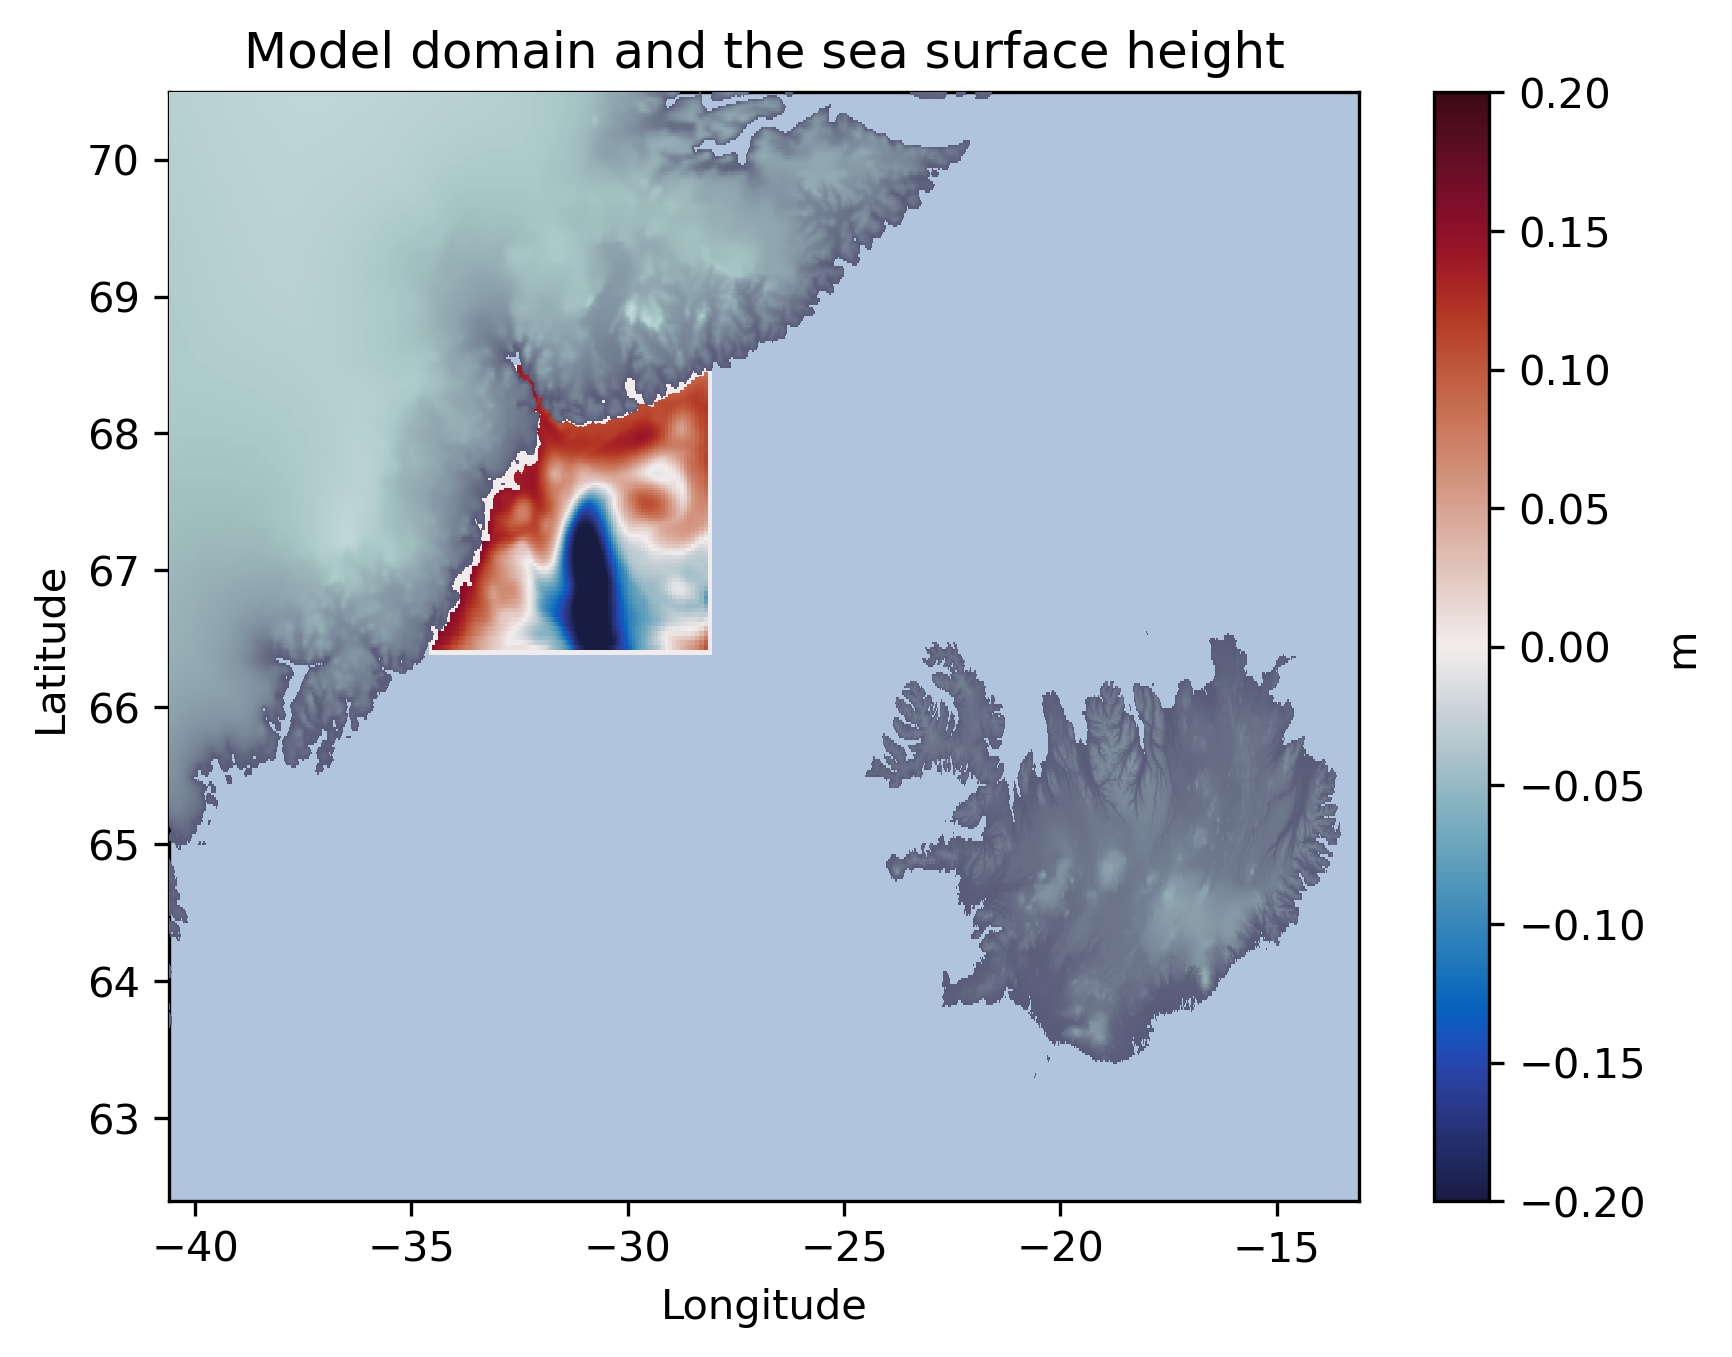

In [5]:
c = plt.pcolormesh(
    fjord._ds.XC, fjord._ds.YC, fjord._ds.Eta[263], vmax=vmax, vmin=-vmax, cmap=cmap
)
plt.pcolormesh(
    etopo.X,
    etopo.Y,
    etopo.Depth,
    cmap="bone",
    vmin=-3000,
    vmax=4500,
    zorder=20,
)
plt.gca().set_facecolor("lightsteelblue")
plt.title("Model domain and the sea surface height")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(c, label="m")
plt.show()

## Doing Interpolation
We are going to use the sea surface height field $\eta$ as an example. 

First, we are going to convert the `xarray.Dataset` to `seaduck.OceData`.

In [6]:
tub = sd.OceData(fjord._ds)

For now, the interpolation points are simply the gridpoints of the dataset.

In [7]:
x = tub.XC.ravel()
y = tub.YC.ravel()
z = np.ones_like(x) * -5.0
t = np.ones_like(x) * sd.utils.convert_time("2008-01-01")

Let's create the `eulerian.Position` object

In [8]:
p = sd.Position().from_latlon(x, y, z, t, data=tub)

Two interpolation kernels are defined here, both of them are default kernels used by the package. However, we are going to "hack" one of them to demonstrate the "cascade" capacity of interpolation.

In [9]:
kernel = sd.KnW()
kernel_to_be_hacked = sd.KnW()

First, we do the normal interpolation on $\eta$ in the normal way, and plot it:

In [10]:
eta = p.interpolate("Eta", kernel)

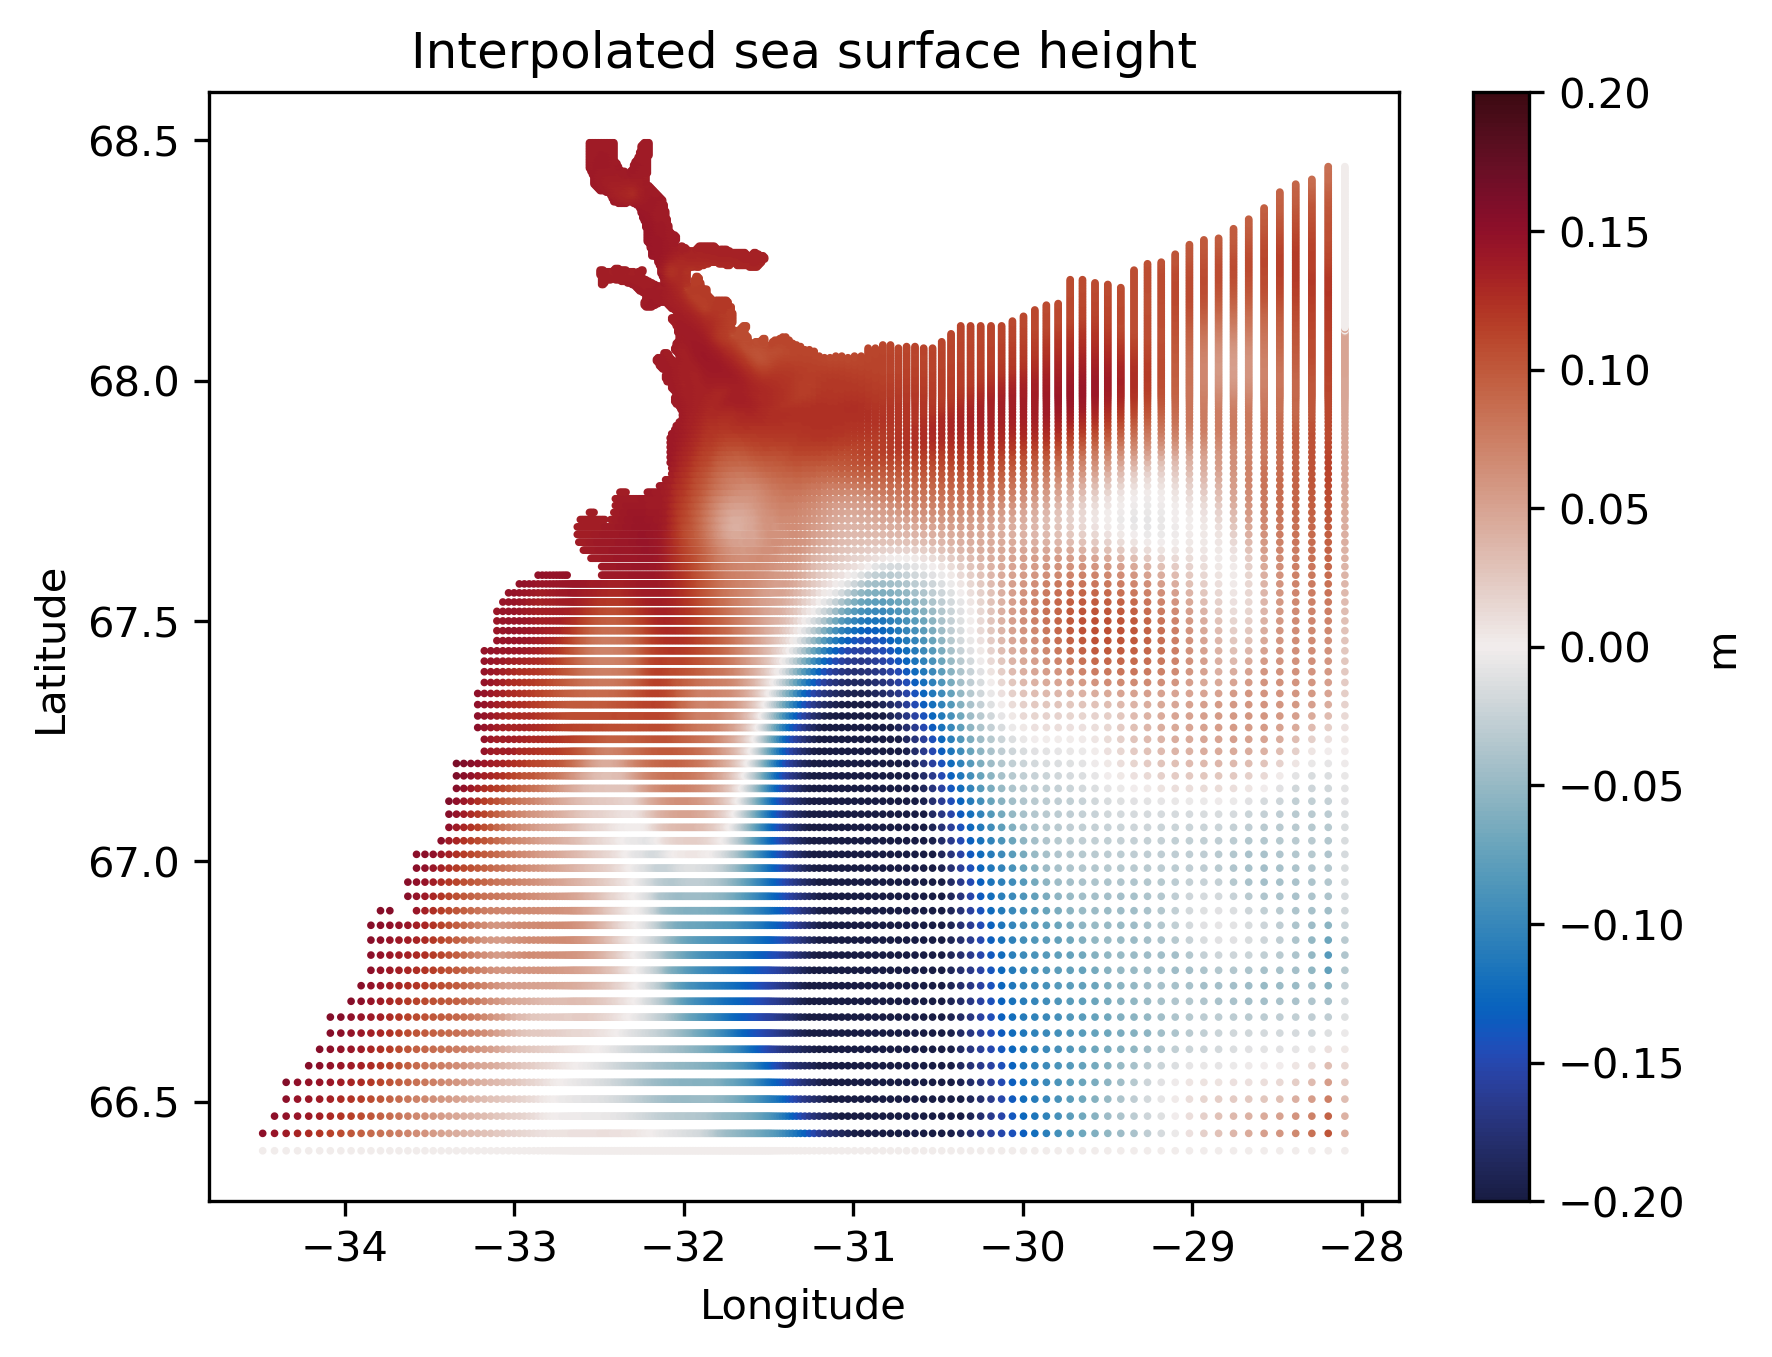

In [11]:
plt.scatter(x, y, c=eta, s=0.7, vmax=vmax, vmin=-vmax, cmap=cmap)
plt.title("Interpolated sea surface height")
plt.colorbar(label="m")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Now let's "hack" the code to make it return the size of the kernels used.

The details of the hack is not very important. But if you're interested you can read the inline comments below.

In [12]:
# The partials of this function is going to replace all the weight functions.
# For legal weight functions, the sum of contribution (weight) should be one,
# but here every neighboring point has contribution of one


def dummy_weight(rx, ry, ans):
    n = len(rx)
    return np.ones((n, ans))


# This is the step that overwrites the existing weight function. Highly not recommended.
kernel_to_be_hacked.hfuncs = [partial(dummy_weight, ans=len(k)) for k in kernel.kernels]
# Create a dataset of ones with the same shape as Eta.
tub["ones"] = xr.ones_like(tub["Eta"])

In [13]:
how_many = p.interpolate("ones", kernel_to_be_hacked)

Now, we can look at what the interpolation package does under the hood.

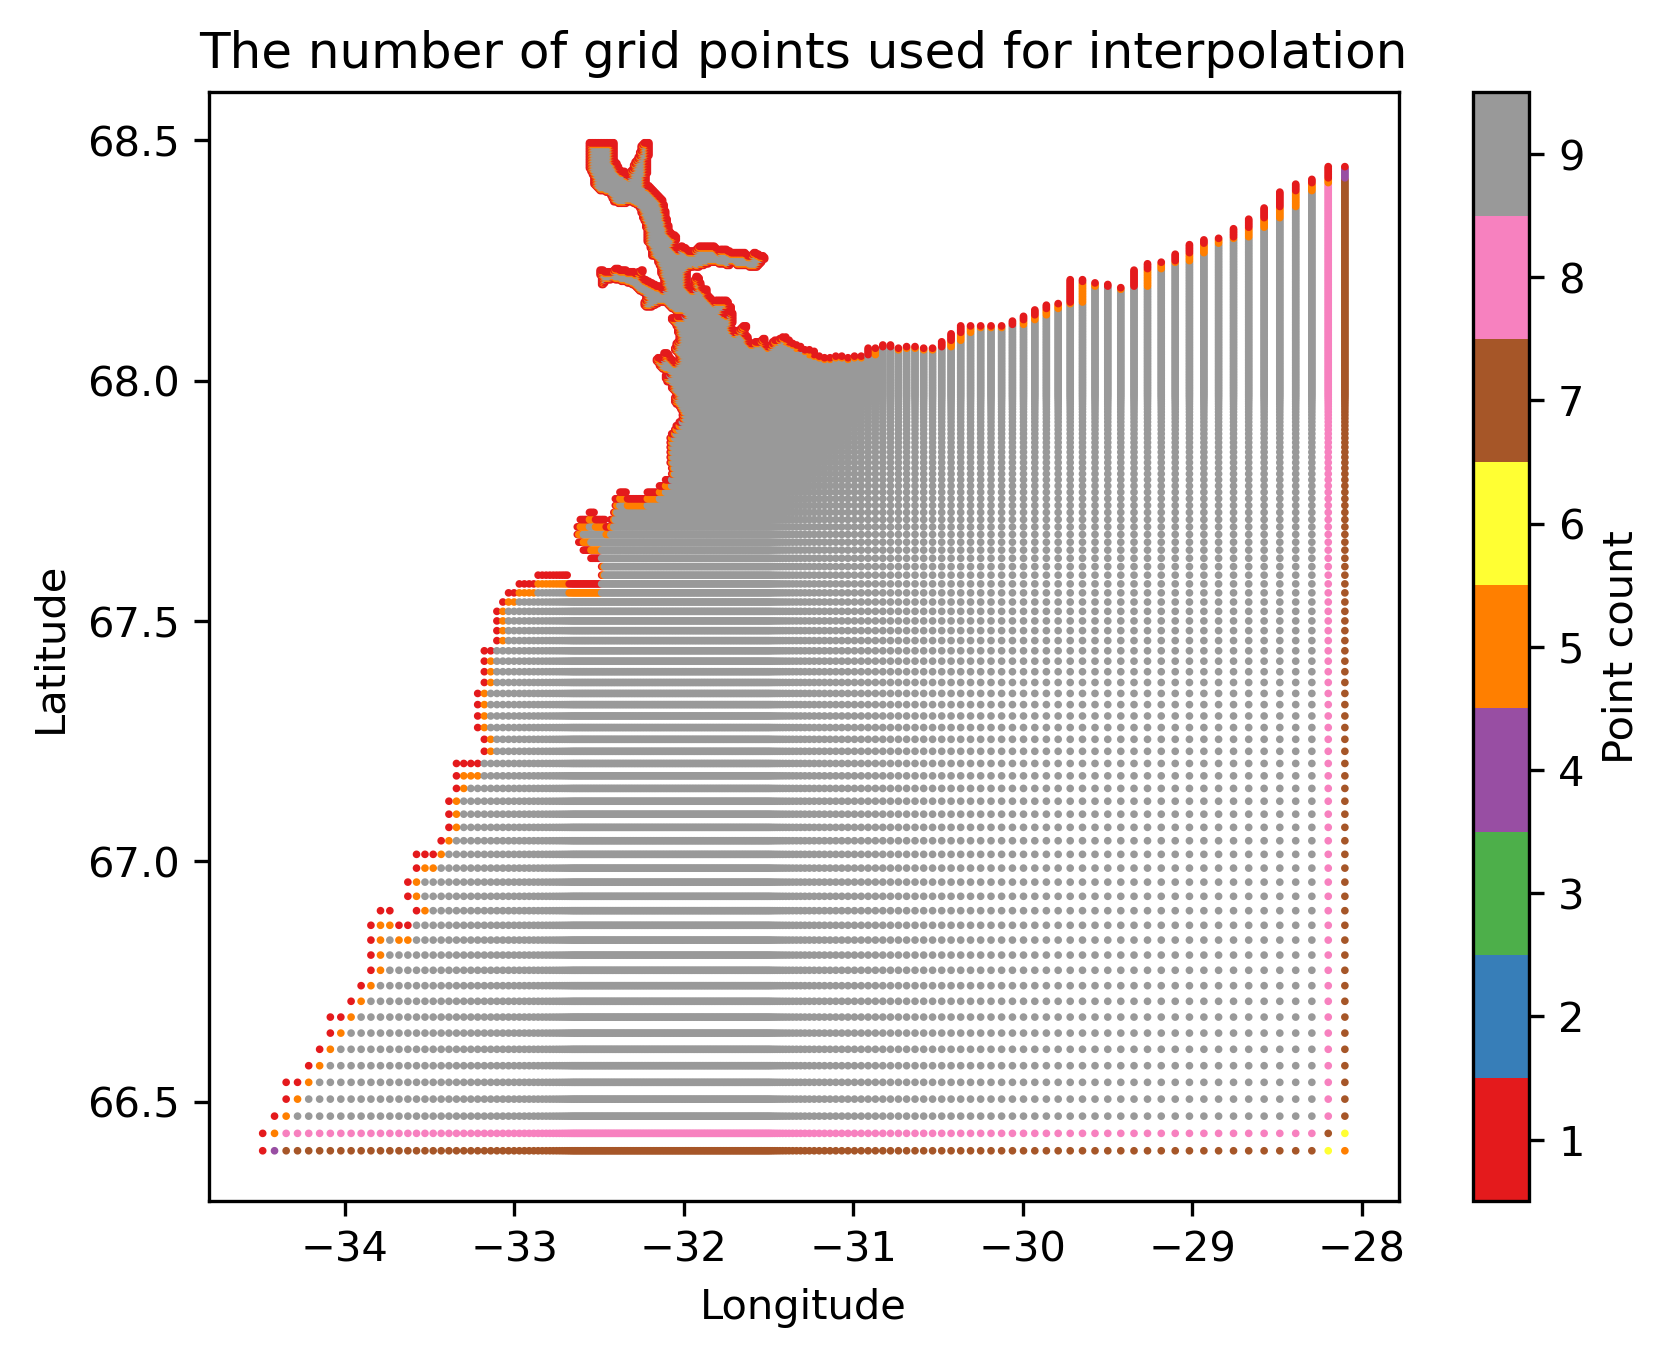

In [14]:
plt.scatter(x, y, c=how_many, s=0.7, cmap="Set1", vmax=9.5, vmin=0.5)
plt.title("The number of grid points used for interpolation")
plt.colorbar(label="Point count")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Filling between

As you have seen earlier, the grid of this dataset has very uneven spacing.

Well, the strength of the `eulerian.Position` object is filling in information (interpolation) between the grid points.
So let's do that. We specify part of the model domain to fill in using the parameters to the `utils.easy_3d_cube` call.

In [15]:
Nlon = 600
Nlat = 100
Ndep = 1
ax, ay, az, at = sd.utils.easy_3d_cube(
    (-34.5, -28.5, Nlon), (66.5, 67.0, Nlat), (-5.0, -5.0, Ndep), "2008-01-01"
)

Create `eulerian.Position` in between, and plot it!

In [16]:
addition = sd.Position().from_latlon(ax, ay, az, at, data=tub)
more_eta = addition.interpolate("Eta", kernel)

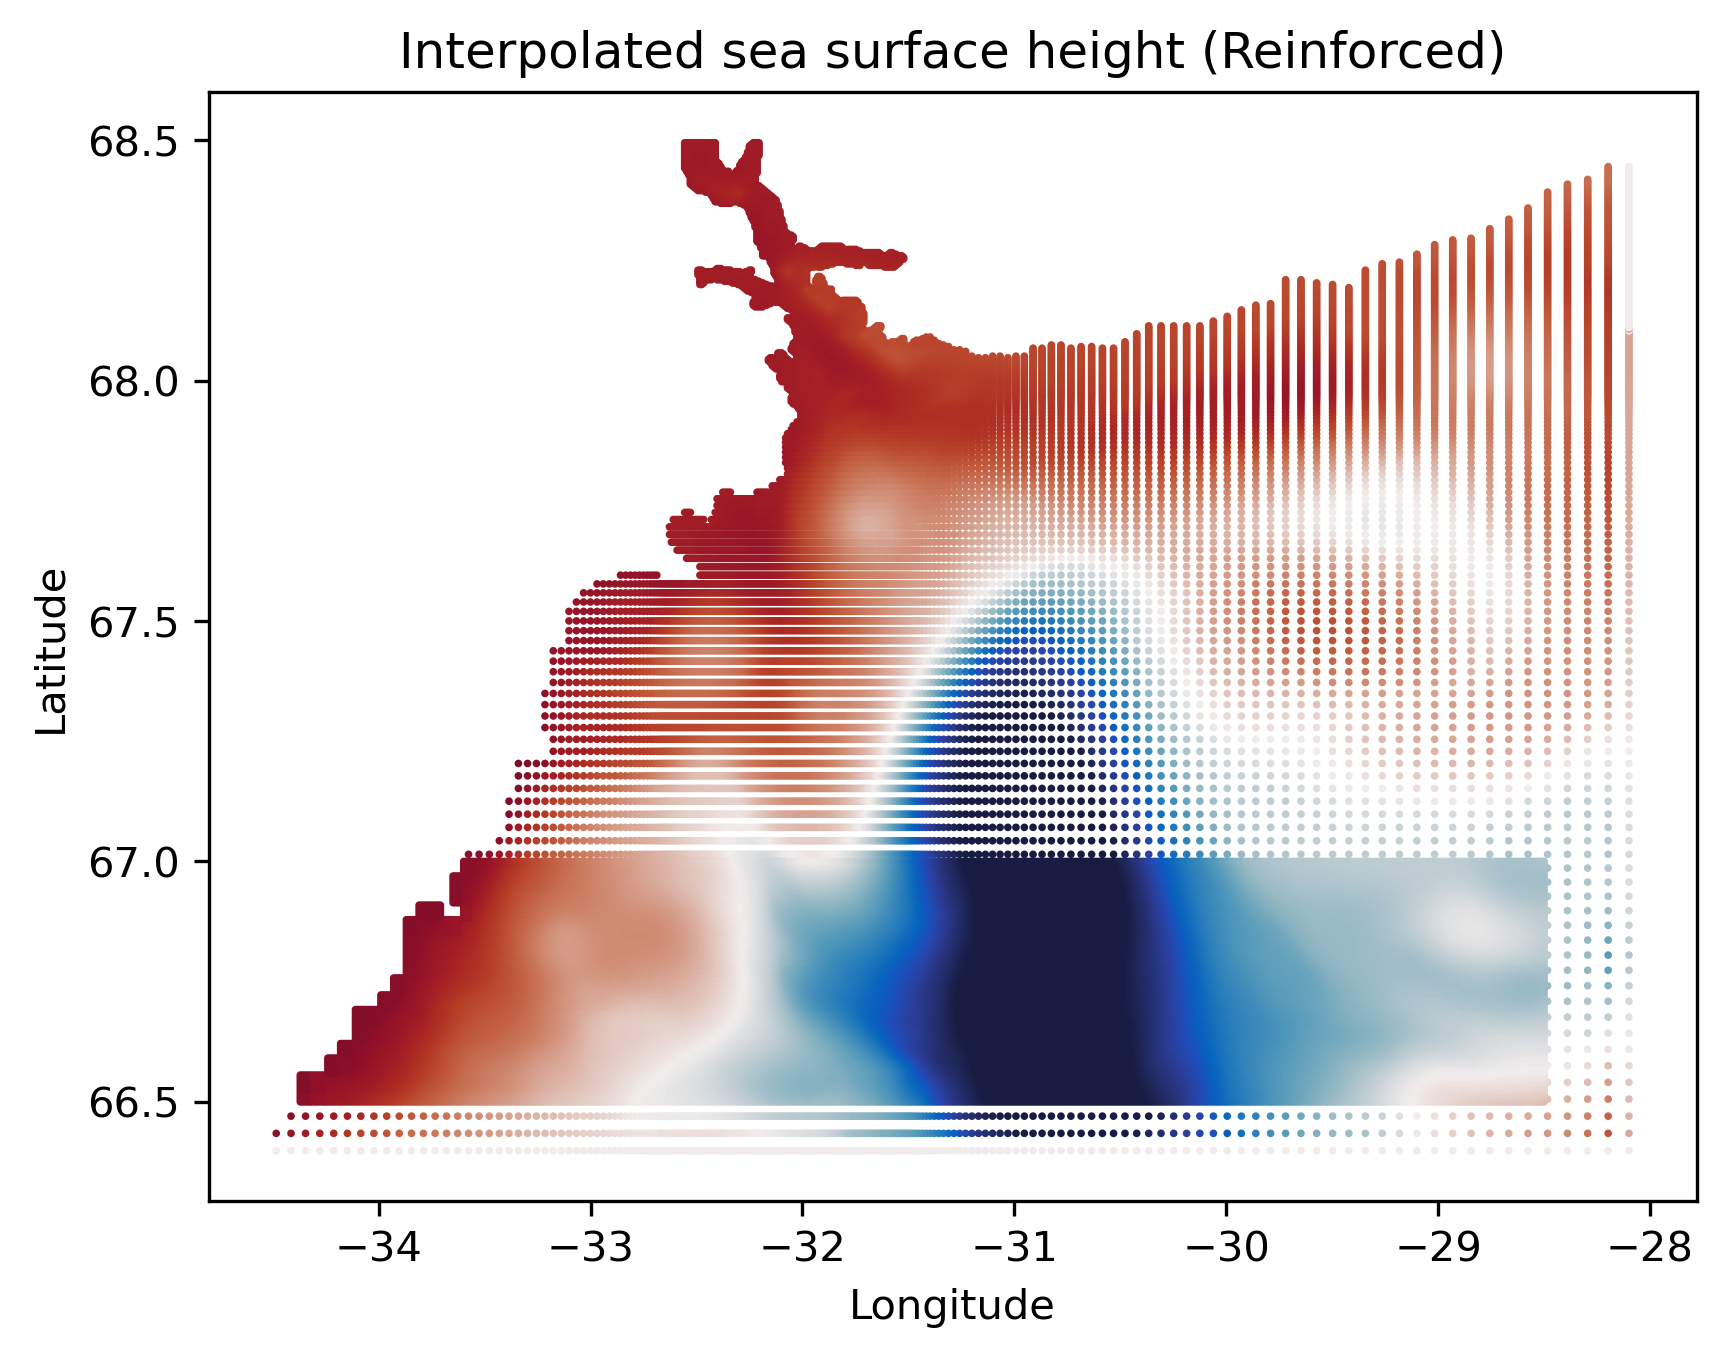

In [17]:
plt.scatter(x, y, c=eta, s=0.7, vmax=vmax, vmin=-vmax, cmap=cmap)
plt.scatter(ax, ay, c=more_eta, s=0.7, vmax=vmax, vmin=-vmax, cmap=cmap)
plt.title("Interpolated sea surface height (Reinforced)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

I'd say the filling-in is done pretty well!